### Deliverable 3: Optimization of Deliverable 2

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import Callback


#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("./resources/charity_data.csv")
application_df.sample(10)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
26396,760574851,CLEARCREEK I S D SUPPORT GROUPS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
18895,473973500,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
29326,830337057,EXPERIMENTAL AIRCRAFT ASSOC,T3,Independent,C1280,Preservation,Trust,1,0,N,5000,1
18841,473823493,TEAM JOSIAH 2K22,T3,Independent,C1200,Preservation,Trust,1,0,N,5000,1
21113,571171772,MONTANA 4-H FOUNDATION INC,T3,CompanySponsored,C2000,Preservation,Trust,1,0,N,5000,0
4538,260380280,SARAHS LAUGHTER CHRISTIAN SUPPORTFOR INFERTILI...,T3,Independent,C1000,Preservation,Trust,1,100000-499999,N,59848,1
17478,471189900,PHI DELTA KAPP INTERNATIONAL INC,T3,CompanySponsored,C2000,ProductDev,Association,1,0,N,5000,0
5980,263695336,PARADISE OF SAMOA,T3,Independent,C1200,Preservation,Trust,1,0,N,5000,1
15940,463504391,LAMBDA THETA ALPHA,T7,CompanySponsored,C1000,ProductDev,Association,1,0,N,5000,0
6637,270271763,PTA UTAH CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN', 'NAME'], axis=1)

<AxesSubplot:>

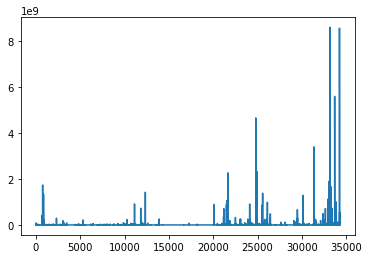

In [3]:
application_df.ASK_AMT.plot()

In [4]:
application_df.ASK_AMT.describe()

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

In [5]:
application_df.INCOME_AMT.value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [6]:
# Look at APPLICATION_TYPE value counts for binning
app_type_counts = application_df.APPLICATION_TYPE.value_counts()

# Determine which values to replace if counts are less than 500?
#replace_application = list(app_type_counts[app_type_counts < 500].index)
replace_application = list(app_type_counts[app_type_counts < 700].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()

# Determine which values to replace if counts are less than 2500?
#replace_class = list(classification_counts[classification_counts < 1000].index)
replace_class = list(classification_counts[classification_counts < 700].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    

In [7]:
# Generate our categorical variable lists
application_cat = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE', 
                   'ORGANIZATION', 'STATUS', 'SPECIAL_CONSIDERATIONS', 'INCOME_AMT']

In [8]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
#encode_df.head()

In [9]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat, axis=1)
#application_df.head()

In [10]:
def split_and_scale(application_df):
    # Split our preprocessed data into our features and target arrays
    y = application_df.IS_SUCCESSFUL.values
    X = application_df.drop('IS_SUCCESSFUL', axis=1).values

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [11]:
# Setup the ModelCheckpoint callback.
class CustomCallback(Callback):
    def __init__(self, filepath):
        os.makedirs(filepath,exist_ok=True)
        self.filepath=filepath
    
    def save_checkpoint(self, checkpoint_path):
        self.model.save_weights(checkpoint_path)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0 and epoch > 0:
            checkpoint_path = f"{self.filepath}/weights.{epoch:02d}.hdf5"
            self.save_checkpoint(checkpoint_path)
            print(f"\nEnd of epoch {epoch}, saved weights")
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_end(self, logs=None):
        checkpoint_path = f"{self.filepath}/weights.final.hdf5"
        self.save_checkpoint(checkpoint_path)
        print(f"\nEnd of training, saved final weights")
        return super().on_train_end(logs=logs)


#### Attempt 1
Drop columns:
- INCOME_AMT, which does not seem to be consistently populated
- SPECIAL_CONSIDERATIONS, which is set to N all but a handful of times

In [12]:
application_df.SPECIAL_CONSIDERATIONS_N.value_counts()

1.0    34272
0.0       27
Name: SPECIAL_CONSIDERATIONS_N, dtype: int64

In [13]:
application_df.INCOME_AMT_0.value_counts()

1.0    24388
0.0     9911
Name: INCOME_AMT_0, dtype: int64

In [14]:
trimmed_app_df = application_df.drop(application_df.columns[application_df.columns.str.startswith('INCOME_AMT')], axis=1)
trimmed_app_df = trimmed_app_df.drop(application_df.columns[application_df.columns.str.startswith('SPECIAL_CONSIDERATIONS')], axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = split_and_scale(trimmed_app_df)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 5
hidden_nodes_layer2 = 3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure
print(nn.summary())

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 170       
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=20,callbacks=CustomCallback('./opt1_checkpoints'))

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"\nModel Evaluation Results:\n  Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/20
804/804 [==============================] - 1s 1ms/step - loss: 0.6262 - accuracy: 0.6684
Epoch 2/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5787 - accuracy: 0.7163
Epoch 3/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5708 - accuracy: 0.7193
Epoch 4/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5672 - accuracy: 0.7235
Epoch 5/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5649 - accuracy: 0.7230
Epoch 6/20
779/804 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.7249
End of epoch 5, saved weights
804/804 [==============================] - 1s 1ms/step - loss: 0.5630 - accuracy: 0.7245
Epoch 7/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5620 - accuracy: 0.7254
Epoch 8/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5612 - accuracy: 0.7262
Epoch 9/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5604 - ac

#### Attempt 2
Add a third hidden layer using the trimmed_app_df from Attempt #1

In [16]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = split_and_scale(trimmed_app_df)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 6
hidden_nodes_layer2 = 6
hidden_nodes_layer3 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure
print(nn.summary())

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 204       
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
 dense_5 (Dense)             (None, 4)                 28        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 279
Trainable params: 279
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=20,callbacks=CustomCallback('./opt2_checkpoints'))

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"\nModel Evaluation Results:\n  Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/20
804/804 [==============================] - 2s 1ms/step - loss: 0.6113 - accuracy: 0.6908
Epoch 2/20
804/804 [==============================] - 1s 2ms/step - loss: 0.5722 - accuracy: 0.7240
Epoch 3/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5668 - accuracy: 0.7252
Epoch 4/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5640 - accuracy: 0.7257
Epoch 5/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5625 - accuracy: 0.7267
Epoch 6/20
776/804 [===========================>..] - ETA: 0s - loss: 0.5609 - accuracy: 0.7279
End of epoch 5, saved weights
804/804 [==============================] - 1s 1ms/step - loss: 0.5617 - accuracy: 0.7272
Epoch 7/20
804/804 [==============================] - 1s 1ms/step - loss: 0.5608 - accuracy: 0.7268
Epoch 8/20
804/804 [==============================] - 1s 2ms/step - loss: 0.5601 - accuracy: 0.7269
Epoch 9/20
804/804 [==============================] - 1s 2ms/step - loss: 0.5595 - ac

#### Attempt 3

Increase number of nodes in the hidden layers

In [18]:
trimmed_app_df = application_df
trimmed_app_df = trimmed_app_df.drop(application_df.columns[application_df.columns.str.startswith('ASK_AMT')], axis=1)
trimmed_app_df = trimmed_app_df.drop(application_df.columns[application_df.columns.str.startswith('SPECIAL_CONSIDERATIONS')], axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = split_and_scale(trimmed_app_df)

# Define the model - deep neural net
number_input_features = len(X_train[0])
# 10 epochs 73.6
hidden_nodes_layer1 = number_input_features / 2
hidden_nodes_layer2 = number_input_features
hidden_nodes_layer3 = 9

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure
print(nn.summary())

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=10,callbacks=CustomCallback('./opt3_checkpoints'))

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"\nModel Evaluation Results:\n  Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                840       
                                                                 
 dense_8 (Dense)             (None, 41)                861       
                                                                 
 dense_9 (Dense)             (None, 9)                 378       
                                                                 
 dense_10 (Dense)            (None, 1)                 10        
                                                                 
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
804/804 [==============================] - 2s 1ms/step - loss: 0.5812 - accuracy: 0.7131
Epoch 2/10
804/804 [==============================] - 1s 2ms/step - loss: 0.556

#### Attempt #4

Try out using the KerasTuner

In [19]:
# Try out KerasTuner
import keras_tuner as kt

In [20]:
trimmed_app_df = application_df
trimmed_app_df = trimmed_app_df.drop(application_df.columns[application_df.columns.str.startswith('ASK_AMT')], axis=1)
trimmed_app_df = trimmed_app_df.drop(application_df.columns[application_df.columns.str.startswith('SPECIAL_CONSIDERATIONS')], axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = split_and_scale(trimmed_app_df)

number_input_features = len(X_train[0])

def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
            hp.Choice('first_units', [int(number_input_features/2), number_input_features, number_input_features*2]),
            input_dim=number_input_features,
            activation='relu'))
  model.add(tf.keras.layers.Dense(
            hp.Choice('second_units', [int(number_input_features/2), number_input_features, number_input_features*2]),
            activation='relu'))
  model.add(tf.keras.layers.Dense(
            hp.Choice('third_units', [int(number_input_features/2), number_input_features, number_input_features*2]),
            activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  return model

In [21]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    directory='try_keras', 
    project_name='try_keras',
    max_epochs=20,
    overwrite=True)

In [22]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
tuner.results_summary()

Trial 30 Complete [00h 00m 50s]
val_accuracy: 0.7341107726097107

Best val_accuracy So Far: 0.735276997089386
Total elapsed time: 00h 09m 41s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in try_keras\try_keras
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
first_units: 82
second_units: 20
third_units: 41
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.735276997089386
Trial summary
Hyperparameters:
first_units: 82
second_units: 41
third_units: 82
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 6fa1301af1fdff488fa012d351f04a93
Score: 0.7349271178245544
Trial summary
Hyperparameters:
first_units: 20
second_units: 41
third_units: 82
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7346938848495483
Trial summary
Hyperparameters:
first_units: 20
second_units: 41
third_units: 20
tuner/epochs: 7
tuner/initial_epoch: 3
t